In [2]:
#Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns',100)

basket_df = pd.read_csv("./csv_files/Trans_by_Basket_50000_Cust_YF_no_XX.csv",parse_dates=[23])

print(basket_df.shape)

basket_df = basket_df.drop(columns = ['basket_id.1','time_id.1','cust_id.1','store_id.1'])

#Find an average frequency between visits?

basket_df_time = basket_df[['cust_id','shop_date']]
test = pd.DataFrame(columns = ['date','diff'])
test['date'] = basket_df_time.groupby('cust_id')['shop_date'].apply(lambda x: x.sort_values())
test['diff'] = test.groupby('cust_id')['date'].diff() / np.timedelta64(1, 'D')
test = test.dropna()

date_diff = test.groupby('cust_id')['diff'].agg(['min', 'max','mean'])
date_diff.columns = ['shop_diff_min','shop_diff_max','shop_diff_mean']

print(date_diff.describe())

(50000, 25)
       shop_diff_min  shop_diff_max  shop_diff_mean
count     390.000000     390.000000      390.000000
mean        5.251282      90.117949       20.827060
std        40.479560     110.307779       48.217457
min         0.000000       5.000000        1.011125
25%         0.000000      26.000000        4.345029
50%         0.000000      48.000000        8.690059
75%         0.000000     104.750000       18.604651
max       624.000000     692.000000      624.000000


In [3]:
X = basket_df[['store_id','std_quantity','nunique_products',
              'n_products','sum_spend','cust_price_sensitivity',
              'basket_size', 'basket_price_sensitivity',
             'basket_type','basket_dominant_mission','store_format','store_region']]

#X['cust_lifestage'].fillna('OT')

#Groupby Customer
scaler = StandardScaler()

# Need to Dummy my variables first

X_cat = X[['cust_price_sensitivity',
              'basket_size', 'basket_price_sensitivity',
             'basket_type','basket_dominant_mission']]
X_num = X[['std_quantity','nunique_products','n_products','sum_spend']]

X_dum = pd.get_dummies(X_cat)
#X_num_scale = pd.DataFrame(scaler.fit_transform(X_num),columns=['std_quantity','nunique_products','n_products','sum_spend'])
           
X_all = pd.concat([X_num,X_dum],axis=1)

X_all = pd.concat([basket_df['cust_id'],X_all],axis=1)

X_all_cust_grp  = X_all.groupby('cust_id').agg({ 'std_quantity' : ['mean'],
                            'nunique_products' : ['mean'],
                            'n_products': ['mean'],
                            'sum_spend': ['mean','max'],
                            'cust_price_sensitivity_LA': ['max'],
                            'cust_price_sensitivity_MM': ['max'],
                            'cust_price_sensitivity_UM': ['max'],
                            'basket_size_L' : ['max', 'sum','count'],
                            'basket_size_M' : ['max', 'sum'],
                            'basket_size_S' : ['max', 'sum'],
                            'basket_price_sensitivity_LA' : ['max', 'sum'],
                            'basket_price_sensitivity_MM' : ['max', 'sum'],
                            'basket_price_sensitivity_UM' : ['max', 'sum'],
                            'basket_type_Full Shop' : ['max', 'sum'], 
                            'basket_type_Small Shop': ['max', 'sum'], 
                            'basket_type_Top Up': ['max', 'sum'],
                            'basket_dominant_mission_Fresh': ['max', 'sum'],
                            'basket_dominant_mission_Grocery': ['max', 'sum'],
                            'basket_dominant_mission_Mixed': ['max', 'sum'],
                            'basket_dominant_mission_Nonfood': ['max', 'sum'] })

X_all_cust_grp.columns = ["_".join(x) for x in X_all_cust_grp.columns.ravel()]

sum_columns = ['basket_size_L_sum', 
               'basket_size_M_sum', 
               'basket_size_S_sum', 
               'basket_price_sensitivity_LA_sum', 
               'basket_price_sensitivity_MM_sum', 
               'basket_price_sensitivity_UM_sum',
               'basket_type_Full Shop_sum', 
               'basket_type_Small Shop_sum', 
               'basket_type_Top Up_sum', 
               'basket_dominant_mission_Fresh_sum',
               'basket_dominant_mission_Grocery_sum',
               'basket_dominant_mission_Mixed_sum',
               'basket_dominant_mission_Nonfood_sum']

for col in sum_columns:
    X_all_cust_grp[col] = X_all_cust_grp[col] / X_all_cust_grp['basket_size_L_count']

X_all_cust_grp.rename(columns={"basket_size_L_count": "basket_count"})

X_all_cust_grp = pd.concat([X_all_cust_grp,date_diff],axis=1)

X_all_cust_grp.head()

X_all_cust_grp_scale = pd.DataFrame(scaler.fit_transform(X_all_cust_grp),
                                    columns=X_all_cust_grp.columns,index=X_all_cust_grp.index)

X_all_cust_grp = X_all_cust_grp[ ~X_all_cust_grp_scale.isna().any(axis=1) ] 

X_all_cust_grp_scale = X_all_cust_grp_scale.dropna()


/home/dan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [4]:
pca_grp = PCA(n_components = 0.8)

X_all_cust_grp_scale_pca = pca_grp.fit_transform(X_all_cust_grp_scale)

#plt.bar(['PC1', 'PC2','PC3','PC4'], [0:3])

#plt.xlabel('Principal Components')
#plt.ylabel('Explained Variance Ratio')

pca_grp.explained_variance_ratio_


array([0.22208452, 0.13920743, 0.09413752, 0.07056533, 0.05453249,
       0.04365926, 0.040212  , 0.03624201, 0.03058937, 0.02667228,
       0.0259719 , 0.02134409])

In [5]:
import itertools

#X_all_cust_grp.drop(columns='cust_id')

model_iterator = itertools.product({'average', 'single', 'complete'}, range(2,10))

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

#X_all_cust_grp_scale = pd.DataFrame(scaler.fit_transform(X_all_cust_grp),
#                                    columns=X_all_cust_grp.columns)

agg_model_list = [ AgglomerativeClustering(affinity = 'cosine', linkage = linkage, 
                  n_clusters = number).fit(X_all_cust_grp_scale_pca) for linkage,number in model_iterator]

agg_model_sil_list = [silhouette_score(X_all_cust_grp_scale_pca,model.labels_, metric = 'cosine') for model in agg_model_list]

model_iterator = itertools.product({'average', 'single', 'complete'}, range(2,10))

agg_model_all_df = pd.DataFrame(model_iterator, columns =['linkage','n_comp'])

agg_model_all_df['sil'] = agg_model_sil_list 

#sns.catplot(x='n_comp',y='sil', hue= 'linkage',data=agg_model_all_df,kind='bar')

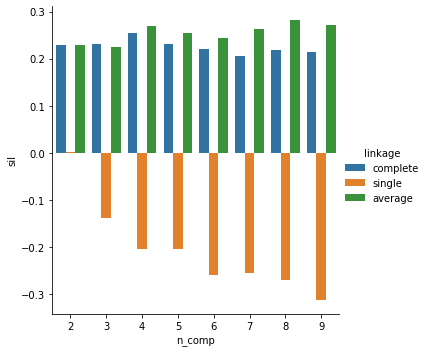

In [6]:
sns.catplot(x='n_comp',y='sil', hue= 'linkage',data=agg_model_all_df,kind='bar')

In [7]:
best_agg_model = AgglomerativeClustering(affinity = 'cosine', linkage = 'complete', 
                  n_clusters = 2).fit(X_all_cust_grp_scale_pca) 

X_zero = X_all_cust_grp_scale.iloc[best_agg_model.labels_==0]
X_one = X_all_cust_grp_scale.iloc[best_agg_model.labels_==1]

print(X_zero.shape[0])
print(X_one.shape[0])

A = (X_zero.describe().T/X_zero.shape[0] - X_one.describe().T/X_one.shape[0])*(X_zero.shape[0]+X_one.shape[0])

print(A.sort_values(by ='mean', ascending=False))

251
139
                                     count      mean       std        min  \
basket_size_L_sum                      0.0  3.079297 -0.320453   2.261624   
nunique_products_mean                  0.0  2.677751  0.051460   2.292883   
n_products_mean                        0.0  2.638886  0.185112   2.225739   
sum_spend_mean                         0.0  2.553214  0.151970   2.108340   
basket_type_Full Shop_sum              0.0  2.324202  0.427750   1.181986   
basket_type_Full Shop_max              0.0  2.124477 -3.018720   3.004370   
sum_spend_max                          0.0  2.029832  0.162397   1.957088   
basket_dominant_mission_Mixed_sum      0.0  1.942920 -0.661454   2.359759   
std_quantity_mean                      0.0  1.863493 -0.045839   2.320920   
basket_type_Top Up_sum                 0.0  1.377480 -0.804402   2.317350   
basket_size_L_count                    0.0  1.050350 -0.804368   1.289041   
basket_size_L_max                      0.0  1.030520 -3.843413   7.0

Text(0.5, 1.0, 'Mean Differences Between Groups (Scaled)')

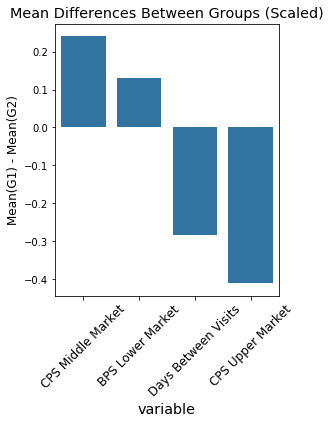

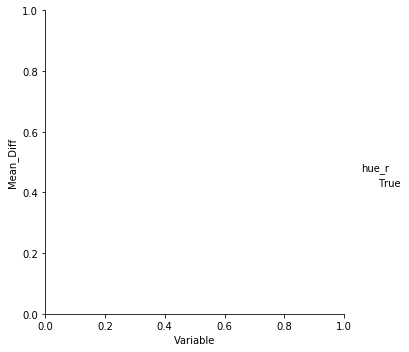

In [18]:
#Bar plot of above....
import scipy.stats as stats

results = [] ; 

test_index = ['cust_price_sensitivity_MM_max',
            'basket_price_sensitivity_LA_sum' ,
            'shop_diff_mean' ,
            'cust_price_sensitivity_UM_max' 
            ]
for var in test_index:
    
    mean_diff = X_zero[var].mean() - X_one[var].mean()

    results.append([var,X_zero[var].mean(),X_one[var].mean(), mean_diff, stats.f_oneway(X_zero[var], X_one[var])[0],stats.f_oneway(X_zero[var], X_one[var])[1] ])

results_df = pd.DataFrame(results,columns = ['Variable','Group_1_mean','Group_2_mean','Mean_Diff','Fstat','P_value'])

#results_df = results_df.sort_values(by = 'Mean_Diff', ascending=False)

results_df['hue_r'] = results_df['Mean_Diff']<3

#plt.rcParams["figure.figsize"] = (8=20, 4)
fig_dims = (4, 5)
fig, ax = plt.subplots(figsize=fig_dims)
chart = sns.catplot(x='Variable',y='Mean_Diff',data=results_df,hue='hue_r',kind='bar', ax=ax)
ax.get_legend().remove()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xticklabels(['CPS Middle Market','BPS Lower Market','Days Between Visits','CPS Upper Market'],fontsize='large')
ax.set_xlabel('variable',fontsize='x-large')
ax.set_ylabel('Mean(G1) - Mean(G2)',fontsize='large')
ax.set_title('Mean Differences Between Groups (Scaled)',fontsize='x-large')


In [9]:
results_df

,Variable,Group_1_mean,Group_2_mean,Mean_Diff,Fstat,P_value,hue_r
2,cust_price_sensitivity_UM_max,-0.143562,0.266752,0.410314,15.525650,0.000097,True
3,shop_diff_mean,-0.100990,0.182364,0.283355,7.279886,0.007278,True
0,cust_price_sensitivity_LA_max,0.040282,-0.062605,-0.102887,0.942005,0.332367,True
1,cust_price_sensitivity_MM_max,0.080224,-0.160641,-0.240864,5.238714,0.022626,True


In [10]:
X_all_cust_grp.head()

,std_quantity_mean,nunique_products_mean,n_products_mean,sum_spend_mean,sum_spend_max,cust_price_sensitivity_LA_max,cust_price_sensitivity_MM_max,cust_price_sensitivity_UM_max,basket_size_L_max,basket_size_L_sum,basket_size_L_count,basket_size_M_max,basket_size_M_sum,basket_size_S_max,basket_size_S_sum,basket_price_sensitivity_LA_max,basket_price_sensitivity_LA_sum,basket_price_sensitivity_MM_max,basket_price_sensitivity_MM_sum,basket_price_sensitivity_UM_max,basket_price_sensitivity_UM_sum,basket_type_Full Shop_max,basket_type_Full Shop_sum,basket_type_Small Shop_max,basket_type_Small Shop_sum,basket_type_Top Up_max,basket_type_Top Up_sum,basket_dominant_mission_Fresh_max,basket_dominant_mission_Fresh_sum,basket_dominant_mission_Grocery_max,basket_dominant_mission_Grocery_sum,basket_dominant_mission_Mixed_max,basket_dominant_mission_Mixed_sum,basket_dominant_mission_Nonfood_max,basket_dominant_mission_Nonfood_sum,shop_diff_min,shop_diff_max,shop_diff_mean
CUST0000272853,0.360594,6.062112,7.919255,8.161056,58.09,1,0,0,1,0.279503,161,1,0.409938,1,0.310559,1,0.403727,1,0.521739,1,0.074534,1,0.093168,1,0.602484,1,0.304348,1,0.316770,1,0.298137,1,0.322981,1,0.062112,0.0,144.0,3.262500
CUST0000275436,0.902515,7.833333,13.500000,14.886667,23.27,1,0,0,1,0.833333,6,1,0.166667,0,0.000000,1,1.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,1,1.000000,1,0.166667,1,0.166667,1,0.666667,0,0.000000,3.0,247.0,149.000000
CUST0000280589,0.442848,6.135747,8.805430,12.708100,58.15,0,0,1,1,0.352941,221,1,0.271493,1,0.375566,1,0.135747,1,0.561086,1,0.303167,1,0.099548,1,0.588235,1,0.312217,1,0.705882,1,0.076923,1,0.212670,1,0.004525,0.0,18.0,3.713636
CUST0000280952,0.399854,7.352941,9.705882,10.367647,24.68,1,0,0,1,0.470588,17,1,0.294118,1,0.235294,1,0.294118,1,0.588235,1,0.117647,1,0.117647,1,0.529412,1,0.352941,1,0.647059,1,0.058824,1,0.294118,0,0.000000,1.0,179.0,36.375000
CUST0000282917,0.512845,8.475000,12.150000,18.175250,122.31,1,0,0,1,0.412500,80,1,0.400000,1,0.187500,1,0.287500,1,0.500000,1,0.212500,1,0.137500,1,0.462500,1,0.400000,1,0.512500,1,0.175000,1,0.237500,1,0.075000,0.0,133.0,10.291139


In [11]:

X_zero_p = X_all_cust_grp.iloc[best_agg_model.labels_==0]

X_one_p = X_all_cust_grp.iloc[best_agg_model.labels_==1]

print('Group_0 total spend',(X_zero_p['sum_spend_mean']*X_zero_p['basket_size_L_count']).sum())
print('Group_1 total spend',(X_one_p['sum_spend_mean']*X_one_p['basket_size_L_count']).sum())

Group_0 total spend 633663.1399999999
Group_1 total spend 114844.84


In [12]:
print(X_zero.shape[0])
print(X_one.shape[0])

251
139


In [13]:
results_df.head()


,Variable,Group_1_mean,Group_2_mean,Mean_Diff,Fstat,P_value,hue_r
2,cust_price_sensitivity_UM_max,-0.143562,0.266752,0.410314,15.525650,0.000097,True
3,shop_diff_mean,-0.100990,0.182364,0.283355,7.279886,0.007278,True
0,cust_price_sensitivity_LA_max,0.040282,-0.062605,-0.102887,0.942005,0.332367,True
1,cust_price_sensitivity_MM_max,0.080224,-0.160641,-0.240864,5.238714,0.022626,True


In [14]:
print(results_df['Variable'] == 'basket_type_Small Shop_sum')

2    False
3    False
0    False
1    False
Name: Variable, dtype: bool


In [15]:
results_df['Variable'] == ["basket_size_S_sum"]

ValueError: Lengths must match to compare

In [ ]:
hue_r